In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

import nltk
nltk.download('punkt_tab')

# Ensure required nltk resources are available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\madel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\madel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\madel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\madel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [5]:
import gzip
from tqdm import tqdm
path_to_file = "review-New_York_10.json.gz"

# Let's load all data
data = []
for i, d in tqdm(enumerate(parse(path_to_file))):  
    data.append(d)

18661975it [03:16, 94940.88it/s] 


In [7]:
df = pd.DataFrame(data)

In [9]:
import re

def remove_translated_reviews(text):
    if isinstance(text, str) and re.search(r'\(Translated by Google\)', text, re.IGNORECASE):
        return np.nan  # Mark for drop
    return text

In [11]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [13]:
df_initclean=df.drop(columns=['name', 'time', 'pics', 'resp'])
df_initclean['text']=df_initclean['text'].apply(remove_translated_reviews)
df_initclean = df_initclean.dropna()
df_initclean['text']=df_initclean['text'].apply(remove_emojis)
df_initclean.drop_duplicates(inplace=True)

In [59]:
n_per_class = 10000
# Sample equal instances per rating
df_sampled = df_initclean.groupby('rating', group_keys=False).apply(lambda x: x.sample(n=min(len(x), n_per_class), random_state=42))
df_sampled.reset_index()
df_sampled

C:\Users\madel\AppData\Local\Temp\ipykernel_12224\1276981019.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,user_id,rating,text,gmap_id
1030933,108754496617711878337,1,Took us long to sit. Only one person that work...,0x89dc072685f8db8d:0x472c97602ebb781d
607821,110913657411615367606,1,I walked in ready to get my tattoo here based ...,0x89c24e6e75ae6bdb:0x62e6927a6eb3310d
2528995,101525478558822638524,1,"Really bad customer service, plus over price.",0x89c2f3f66d608019:0x134316ff67a75ae3
863351,100700392448875044171,1,They have a youg lady that works there and she...,0x89c2599e515bf4dd:0x4f079e048a26869d
347529,106010706783677566665,1,"Disgusting, came wait for 15 minutes, while th...",0x89c3291acfa48871:0x3434bc5ee5656c46
...,...,...,...,...
15127484,102217410848262083193,5,"Bobby,'s is the best go to for reasonable pric...",0x89c25b3eac517413:0x8294213d52523b1f
16440475,108879028250115321635,5,This Arby was good,0x89c261f71414037d:0xbc8c70b3359c3428
14221436,113187475746250248467,5,"I've always enjoy shopping here, clean and fas...",0x89c2589d18cdf6d7:0x944cb15bd440e1f4
7116054,116671577511763781855,5,Had one of those meals where everything was ex...,0x89c259d6e1ed322b:0x8d06611d6f84ff6e


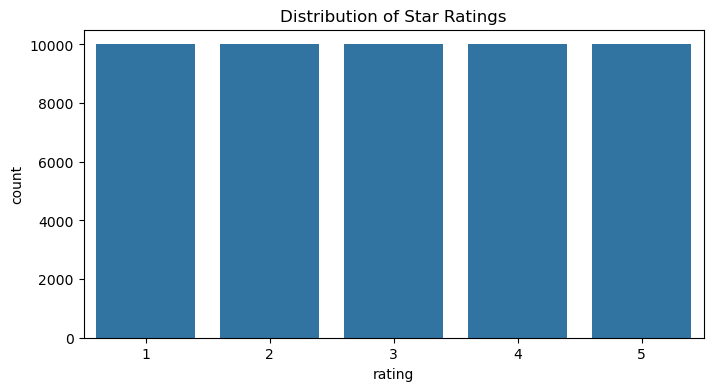

In [61]:
# EDA - double check distribution of ratings in dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of ratings
plt.figure(figsize=(8,4))
sns.countplot(data=df_sampled, x='rating', order=sorted(df_sampled['rating'].unique()))
plt.title("Distribution of Star Ratings")
plt.show()

In [63]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)     # Remove extra whitespace
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [65]:
df_cleaned = df_sampled.copy()
df_cleaned['clean_review']=df_cleaned['text'].apply(preprocess_text)
df_cleaned

,user_id,rating,text,gmap_id,clean_review
1030933,108754496617711878337,1,Took us long to sit. Only one person that work...,0x89dc072685f8db8d:0x472c97602ebb781d,took u long sit one person worked want go like...
607821,110913657411615367606,1,I walked in ready to get my tattoo here based ...,0x89c24e6e75ae6bdb:0x62e6927a6eb3310d,walked ready get tattoo based good review reco...
2528995,101525478558822638524,1,"Really bad customer service, plus over price.",0x89c2f3f66d608019:0x134316ff67a75ae3,really bad customer service plus price
863351,100700392448875044171,1,They have a youg lady that works there and she...,0x89c2599e515bf4dd:0x4f079e048a26869d,youg lady work steal card info order phone use...
347529,106010706783677566665,1,"Disgusting, came wait for 15 minutes, while th...",0x89c3291acfa48871:0x3434bc5ee5656c46,disgusting came wait minute talk b even apolog...
...,...,...,...,...,...
15127484,102217410848262083193,5,"Bobby,'s is the best go to for reasonable pric...",0x89c25b3eac517413:0x8294213d52523b1f,bobby best go reasonable priced house hold item
16440475,108879028250115321635,5,This Arby was good,0x89c261f71414037d:0xbc8c70b3359c3428,arby good
14221436,113187475746250248467,5,"I've always enjoy shopping here, clean and fas...",0x89c2589d18cdf6d7:0x944cb15bd440e1f4,ive always enjoy shopping clean fast service w...
7116054,116671577511763781855,5,Had one of those meals where everything was ex...,0x89c259d6e1ed322b:0x8d06611d6f84ff6e,one meal everything excellent green salad grea...


In [25]:
# theme extraction (topic modelling)
!pip install bertopic
!pip install umap-learn

In [164]:
# filter out reviews that are shorter than 5 words to improve topic modelling
df_longreviews = df_cleaned[df_cleaned['clean_review'].str.split().str.len() >= 5].copy()

from bertopic import BERTopic

# Extract the reviews for modeling
docs_new = df_longreviews['clean_review'].tolist()

# Create BERTopic model
topic_model_new = BERTopic(language="english", verbose=True, nr_topics="auto")

# Extract topics and probabilities
topics_new, probs_new = topic_model_new.fit_transform(docs_new)

# Add topics back to DataFrame
df_longreviews['topic'] = topics_new

2025-04-14 14:10:40,074 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1064 [00:00<?, ?it/s]

2025-04-14 14:21:43,976 - BERTopic - Embedding - Completed ✓
2025-04-14 14:21:43,980 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-14 14:22:08,385 - BERTopic - Dimensionality - Completed ✓
2025-04-14 14:22:08,386 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-14 14:22:13,315 - BERTopic - Cluster - Completed ✓
2025-04-14 14:22:13,315 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-14 14:22:14,275 - BERTopic - Representation - Completed ✓
2025-04-14 14:22:14,275 - BERTopic - Topic reduction - Reducing number of topics
2025-04-14 14:22:15,478 - BERTopic - Topic reduction - Reduced number of topics from 271 to 47


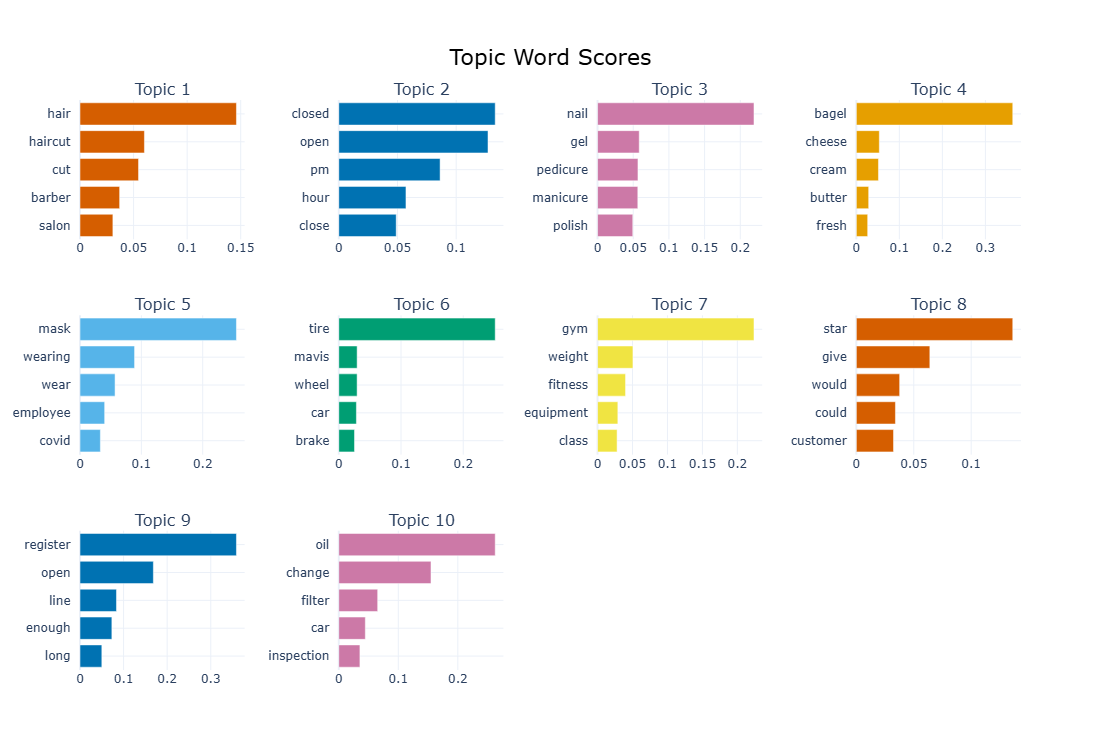

In [188]:
topic_model_new.get_topic_info()

# Visualize top topics
topic_ids = topic_info[(topic_info['Topic'] > 0) & (topic_info['Topic'] <= 10)]['Topic'].tolist()
topic_model_new.visualize_barchart(top_n_topics=None, topics=topic_ids)

In [184]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Extract tokenized versions of documents
df_top10_new = df_longreviews[df_longreviews['topic'].isin(range(1, 11))]
docs = df_top10_new['clean_review'].tolist()
tokenized_docs = [doc.split() for doc in docs]

# Get only the top 10 topic IDs used in df_top10
top_10_topic_ids = set(df_top10_new['topic'].unique())

# Get BERTopic's topic word lists
all_topics = topic_model_new.get_topics()

# Select only those topic word lists that correspond to top 10 topics
topic_words = [
    [word for word, _ in all_topics[topic_id]]
    for topic_id in top_10_topic_ids
    if topic_id in all_topics
]

# Create dictionary and corpus for coherence calculation
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# Calculate coherence
coherence_model = CoherenceModel(
    topics=topic_words, 
    texts=tokenized_docs, 
    dictionary=dictionary, 
    coherence='c_v'  # You can also try 'u_mass', 'c_uci', 'c_npmi'
)

coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.6115632859237221


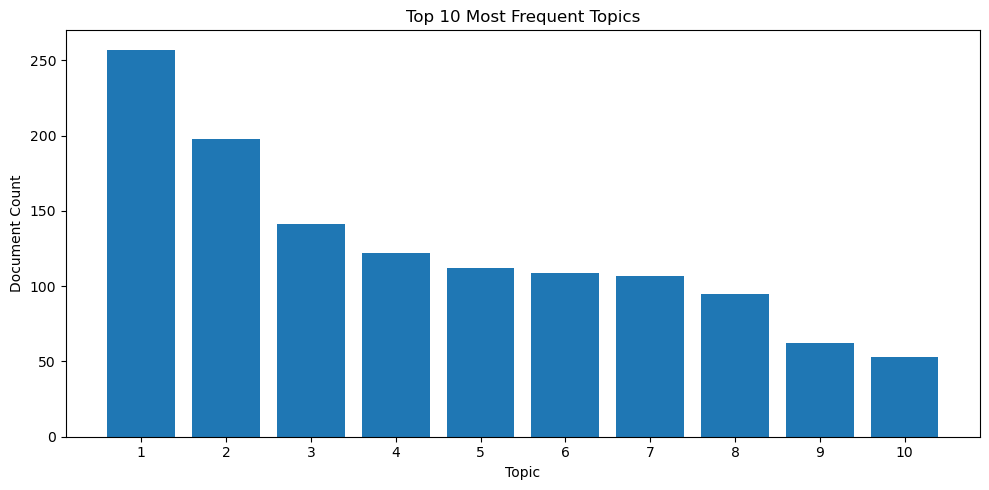

In [190]:
topic_sizes = topic_model_new.get_topic_info()
topic_sizes = topic_sizes[topic_sizes.Topic > 0]  # Remove outlier topic

# Sort by count and keep only top 10
top10_topics = topic_sizes.sort_values("Count", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(top10_topics["Topic"].astype(str), top10_topics["Count"])
plt.title("Top 10 Most Frequent Topics")
plt.ylabel("Document Count")
plt.xlabel("Topic")
plt.tight_layout()
plt.show()

In [196]:
from scipy.stats import entropy

# Get topic info and exclude outlier
topic_info = topic_model_new.get_topic_info()
topic_info = topic_info[topic_info.Topic > 0]

# Get top 10 topics by count
top10_info = topic_info.sort_values("Count", ascending=False).head(10)

# Normalize counts into a probability distribution
topic_counts = top10_info["Count"].values
topic_probs = topic_counts / topic_counts.sum()

# Compute entropy
distribution_entropy = entropy(topic_probs)

print(f"Topic Distribution Entropy (Top 10): {distribution_entropy:.4f}")

Topic Distribution Entropy (Top 10): 2.2027


In [ ]:
from scipy.stats import spearmanr
correlation_coefficient, p_value = spearmanr(df_top10_new['topic'], df_top10_new['rating'])

print("Spearman's correlation coefficient:", correlation_coefficient)
print("P-value:", p_value)

Spearman's correlation coefficient: -0.03737864663764101
P-value: 0.005611857924715768
